In [1]:
import pandas as pd
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

interval = "5"

nifty_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty_df.Symbol.tolist()]

data_path = "../data5m"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, interval, start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, interval)

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

Error fetching data for NSE:OLAELEC-EQ: 'candles'


Loading 5min data: 100%|██████████| 200/200 [00:00<00:00, 273.58it/s]


In [ ]:
from lib import Bank, PositionManager, show_equity_curve
from bb_mean_rev import backtest

params = {
    'initial_capital': 500000,
    'max_positions': 5,
    'bb_period': 20,
    'bb_sd': 2.2,
    'start_date': '2020-04-01',
    'end_date': '2020-07-01',
}


bank = Bank(params['initial_capital'])
pm = PositionManager(bank, brokerage=0)

tearsheet, trades = backtest(df.copy(), pm, params, show_pb=True)
print(pd.DataFrame({
    "Metrics": tearsheet.keys(),
    "Values": tearsheet.values(),
}))
show_equity_curve(trades)

In [ ]:
# trades[(trades.exit_time > pd.Timestamp("2023-01-01")) & (trades.exit_time < pd.Timestamp("2023-06-01"))].to_csv("bb_mean_rev_trades.csv", index=False)
trades.to_csv("bb_mean_rev_trades.csv", index=False)

In [ ]:
((trades.exit_price - trades.avg_entry_price)/trades.avg_entry_price * 100).plot()

                      Metrics                    Values
0                      Period  2020-04-03 to 2020-08-28
1            Starting capital                    500000
2               Final capital                  939313.3
3                Total Trades                      1082
4                     Winners                       710
5                      Losers                       372
6               Profit factor                  1.921479
7       Active Position Count                         0
8   Max holding period (days)                         6
9   Avg holding period (days)                         0
10               Win Rate (%)                 65.619224
11               Total Profit                  439313.3
12                 Avg Profit               1290.227451
13                   Avg Loss              -1281.581156
14            Total Brokerage                         0
15                  Total Tax                  69601.53
16                  Total MTF                   

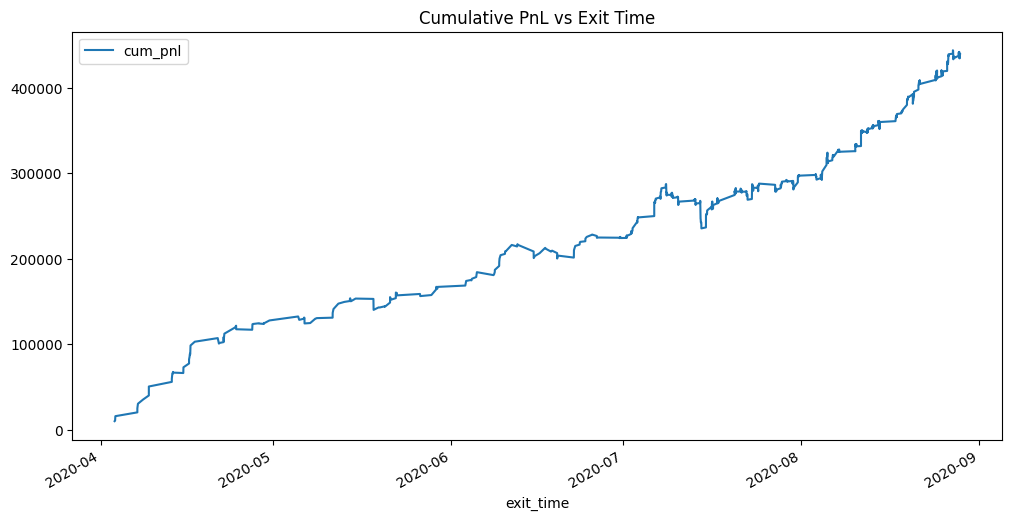

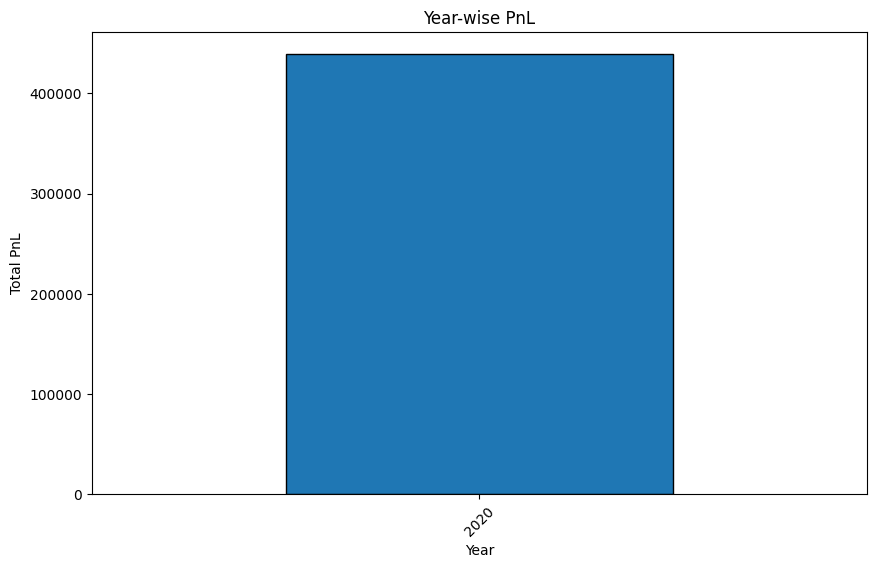

In [22]:
import os
import pandas as pd
from lib import show_equity_curve

def generate_tearsheet(initial_capital, pm: PositionManager, trades=None):
    if trades is None:
        trades = pm.get_trades()

    if len(trades) == 0:
        return {}, trades
    
    # Ensure entry_time and exit_time are datetime
    trades['entry_time'] = pd.to_datetime(trades['entry_time'])
    trades['exit_time'] = pd.to_datetime(trades['exit_time'])
    trades['returns'] = (trades['pnl'] / (trades['avg_entry_price'] * trades['quantity']))

    # Total trades
    total_trades = len(trades)

    # Win rate
    win_trades = (trades['pnl'] > 0).sum()
    win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

    # Profit
    total_profit = trades['pnl'].sum()
    avg_profit = trades[trades.pnl > 0].pnl.mean()
    avg_loss = trades[trades.pnl <= 0].pnl.mean()

    # Total tax
    total_tax = trades['tax'].sum()

    # Total brokerage
    total_brokerage = trades['brokerage'].sum()

    # MTF charge
    total_mtf_charge = trades['mtf_charge'].sum()

    # CAGR calculation
    start = trades['entry_time'].min()
    end = trades['exit_time'].max()
    years = (end - start).days / 365.25
    initial = initial_capital  # initial_capital from your code
    final = initial + total_profit
    cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

    # Active positions
    active_position_count = 0
    if pm is not None:
        active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

    # Period
    period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

    # Max holding period
    max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
    avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

    # Final capital
    final_capital = initial + total_profit


    # Calculate drawdown
    trades['cum_pnl'] = initial_capital + trades['pnl'].cumsum()

    trades['cum_max'] = trades['cum_pnl'].cummax()
    trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
    trades['drawdown_pct'] = trades['drawdown'] / trades['cum_max'] * 100
    avg_dd_perc = trades['drawdown_pct'].mean()
    max_drawdown = trades['drawdown'].min()
    max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

    number_of_losses = len(trades[trades['pnl'] < 0])
    number_of_wins = len(trades[trades['pnl'] > 0])
    profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

    # Tearsheets summary
    tearsheet = {
        'Period': period,
        'Starting capital': initial_capital,
        'Final capital': final_capital,
        'Total Trades': total_trades,
        'Winners': number_of_wins,
        'Losers': number_of_losses,
        'Profit factor': profit_factor if profit_factor else "N/A",
        'Active Position Count': active_position_count,
        'Max holding period (days)': max_holding_period,
        'Avg holding period (days)': avg_holding_period,
        'Win Rate (%)': win_rate,
        'Total Profit': total_profit,
        'Avg Profit': avg_profit,
        'Avg Loss': avg_loss,
        'Total Brokerage': total_brokerage,
        'Total Tax': total_tax if total_tax else "N/A",
        'Total MTF': total_mtf_charge if total_mtf_charge else "N/A",
        'CAGR (%)': cagr if cagr else "N/A",
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown_pct,
        'Avg Drawdown (%)': avg_dd_perc
    }
    
    return tearsheet, trades

dfs = []
for f in os.listdir("trades"):
    df = pd.read_csv(os.path.join("trades", f))
    dfs.append(df)
all_trades = pd.concat(dfs).reset_index(drop=True)
tearsheet, trades = generate_tearsheet(500000, None, all_trades)
print(pd.DataFrame({
    "Metrics": tearsheet.keys(),
    "Values": tearsheet.values(),
}))
show_equity_curve(all_trades)

In [2]:
existing_data = pd.read_parquet("../data5m/NSE:ABB-EQ-5m-EQ.parquet")

In [3]:
import datetime as dt

new_date = existing_data.tail(1).iloc[0].name.date() + dt.timedelta(days=1)
dt.datetime.combine(new_date, dt.datetime.min.time())

datetime.datetime(2025, 10, 11, 0, 0)